**Table of Content:**
* [Get Data](#1)
* [Popular Recommendation System](#2)
* [Memory Based - Collaborative Filtering](#3)
* [Model Based - Collaborative Filtering](#4)
* [Weighted Hybrid Recommendation System](#5)
* [Get Recommendation](#6)
* [Evaluation](#7)

If this notebook helped you, **Please Upvote**.


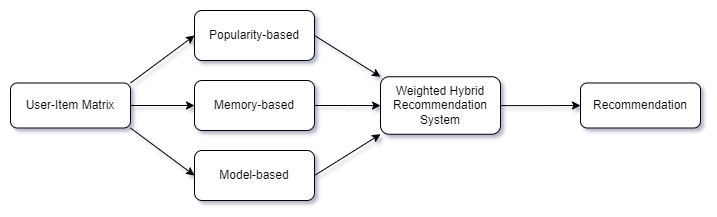

The goal of this project is to create a more effective recommendation system. This allows Santander bank to better meet the individual needs of all customers. To achieve this, the user-item matrix will be used containing the ID of consumers and the products they owned as of May 28, 2015. Then, recommendations in three different recommendation models will be calculated. It will be the popularity-based model, the memory-based collaborative filtering model, and the model-based collaborative filtering model. Then all three recommendations models will be combined into the weighted hybrid recommendation system. The result will be evaluated using average precision metrics.

# 🏦 Santander Product Recommendation Challenge

## 📌 Problem Statement

Santander Bank has provided **1.5 years of customer behavior data** to predict which new banking products a customer will purchase. 

- The dataset spans from **January 28, 2015** to **June 28, 2016**.
- Each month, the data records whether a customer owns specific financial products (e.g., **credit card, savings account, mortgage, etc.**).
- Our goal is to predict **which additional products a customer will acquire in June 2016**, beyond what they already had in May 2016.

---

## 🎯 Objective

Given the historical data, we need to **predict new product purchases** for each customer in the last month (**June 28, 2016**). These products are represented by columns named **ind_(xyz)_ult1**, which correspond to the **25th to 48th columns** in the dataset.

- **Train Data:** Contains customer records from **January 2015 to May 2016**.
- **Test Data:** Includes customer records until **May 2016**, and we must predict purchases in **June 2016**.
- **Evaluation:** The leaderboard is split into public and private sets randomly.

---

## ⚠️ Important Notes
- The data has been **anonymized** and **does not contain real Santander customers**.
- This dataset **is not representative** of Spain’s actual customer base.

---

## 📂 Dataset Overview

- **Time-based split**: The train and test datasets are separated by time.
- **Binary classification**: Each product column (ind_(xyz)_ult1) is a **binary indicator** (1 = product owned, 0 = not owned).
- **Prediction Task**: Identify which **new** products a customer will purchase in June 2016.

Let's explore the dataset and build a predictive model! 🚀


In [124]:
import numpy as np 
import pandas as pd 
import random
from timeit import default_timer as timer

<a id="1"></a>
## Get Data
The dataset contains purchase data about the bank's customers and the bank's products.
The data starts at 2015-01-28 and has monthly records of products a customer has, such as "credit
card", "savings account", etc. 

In [125]:
dtype_list = {'ind_cco_fin_ult1': 'uint8', 'ind_deme_fin_ult1': 'uint8',
            'ind_aval_fin_ult1': 'uint8', 'ind_valo_fin_ult1': 'uint8',
            'ind_reca_fin_ult1': 'uint8', 'ind_ctju_fin_ult1': 'uint8',
            'ind_cder_fin_ult1': 'uint8', 'ind_plan_fin_ult1': 'uint8',
            'ind_fond_fin_ult1': 'uint8', 'ind_hip_fin_ult1': 'uint8',
            'ind_pres_fin_ult1': 'uint8', 'ind_nomina_ult1': 'Int64', 
            'ind_cno_fin_ult1': 'uint8', 'ind_ctpp_fin_ult1': 'uint8',
            'ind_ahor_fin_ult1': 'uint8', 'ind_dela_fin_ult1': 'uint8',
            'ind_ecue_fin_ult1': 'uint8', 'ind_nom_pens_ult1': 'Int64',
            'ind_recibo_ult1': 'uint8', 'ind_deco_fin_ult1': 'uint8',
            'ind_tjcr_fin_ult1': 'uint8', 'ind_ctop_fin_ult1': 'uint8',
            'ind_viv_fin_ult1': 'uint8', 'ind_ctma_fin_ult1': 'uint8',
            'ncodpers' : 'uint32'} 

In [126]:
name_col = ['ncodpers', 'fecha_dato', 'ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1',
               'ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1',
               'ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1',
               'ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1',
               'ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1',
               'ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1',
               'ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1',
               'ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']

In [127]:
# alternative way to read large csv file
# df_train = pd.read_csv('../input/santander-product-recommendation/train_ver2.csv.zip', nrows=2e6,
#                      dtype=dtype_list, 
#                        usecols=name_col
#                     )

In [128]:
start = timer()
# read a large csv file using chunks with specified dtype and usecols parameters to optimize memory usage
reader = pd.read_csv('./df_train_small.csv.zip', chunksize=1e6,
                     dtype=dtype_list, usecols=name_col)

# concatenate the data from all the chunks into a single dataframe
df_train = pd.concat([chunk for chunk in reader])
df_train.shape

(13647309, 26)

In [129]:
df_train.columns

Index(['fecha_dato', 'ncodpers', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1',
       'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1',
       'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
       'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1',
       'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
       'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1',
       'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
       'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1',
       'ind_recibo_ult1'],
      dtype='object')

In [131]:
# save a small version of the train set (50MB)
# df_train.to_csv('df_train_small.csv.zip', index=False,
#                 compression = {'method' : 'zip', 'archive_name' : 'df_train_small.csv'})

In [132]:
# Set Pandas to display all columns
pd.set_option('display.max_columns', None)

# Show 5 random rows with all 26 columns
df_train.sample(5)


,fecha_dato,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
564866,2015-01-28,490358,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12763258,2016-05-28,682203,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7515298,2015-11-28,1508415,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5080255,2015-08-28,1382793,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1583797,2015-03-28,1214348,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Dataset Columns Overview 📊

Below is the list of **26 columns** present in the dataset:

- **fecha_dato**: Date of the record.
- **ncodpers**: Unique customer identifier.
- **ind_ahor_fin_ult1**: Saving Account indicator.
- **ind_aval_fin_ult1**: Guarantees indicator.
- **ind_cco_fin_ult1**: Current Accounts indicator.
- **ind_cder_fin_ult1**: Derivada Account indicator.
- **ind_cno_fin_ult1**: Payroll Account indicator.
- **ind_ctju_fin_ult1**: Junior Account indicator.
- **ind_ctma_fin_ult1**: Más particular Account indicator.
- **ind_ctop_fin_ult1**: Particular Account indicator.
- **ind_ctpp_fin_ult1**: Particular Plus Account indicator.
- **ind_deco_fin_ult1**: Short-term deposits indicator.
- **ind_deme_fin_ult1**: Medium-term deposits indicator.
- **ind_dela_fin_ult1**: Long-term deposits indicator.
- **ind_ecue_fin_ult1**: E-account indicator.
- **ind_fond_fin_ult1**: Investment Funds indicator.
- **ind_hip_fin_ult1**: Mortgage indicator.
- **ind_plan_fin_ult1**: Pensions indicator.
- **ind_pres_fin_ult1**: Loans indicator.
- **ind_reca_fin_ult1**: Taxes indicator.
- **ind_tjcr_fin_ult1**: Credit Card indicator.
- **ind_valo_fin_ult1**: Securities indicator.
- **ind_viv_fin_ult1**: Home Account indicator.
- **ind_nomina_ult1**: Payroll indicator.
- **ind_nom_pens_ult1**: Pensions indicator.
- **ind_recibo_ult1**: Direct Debit indicator.

Each column (except `fecha_dato` and `ncodpers`) represents whether a **customer has a particular financial product (1 = Yes, 0 = No)**.

---
📌 **Next Steps:**
- Check for missing values.
- Perform exploratory data analysis (EDA).
- Implement feature engineering for better insights.


In [133]:
df_train.fecha_dato.unique()

array(['2015-01-28', '2015-02-28', '2015-03-28', '2015-04-28',
       '2015-05-28', '2015-06-28', '2015-07-28', '2015-08-28',
       '2015-09-28', '2015-10-28', '2015-11-28', '2015-12-28',
       '2016-01-28', '2016-02-28', '2016-03-28', '2016-04-28',
       '2016-05-28'], dtype=object)

In [134]:
# # data will be trained on '2015-05-28'
# df_train1505 = df_train[df_train.fecha_dato == '2015-05-28']
# df_train1505 = df_train1505.drop(['fecha_dato'], axis=1, inplace=False)
# df_train1505 = df_train1505.fillna(0)
# df_train1505.shape

In [135]:
# data will be trained on '2015-05-28'
df_train1505 = df_train[df_train.fecha_dato == '2015-05-28']
df_train1505 = df_train1505.drop(['fecha_dato'], axis=1, inplace=False)
df_train1505 = df_train1505.fillna(0)
df_train1505.shape

(631957, 25)

In [136]:
df_train1505.head()

,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
2512427,1061260,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2512428,1061283,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2512429,1061284,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2512430,1061336,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2512431,1061286,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<a id="2"></a>
## Popular Recommendation System

# 📊 Popularity-Based Product Recommendation

## 🔍 Function: `popularity_based(df)`

### 🛠️ Purpose:
This function calculates the **probability** of each financial product being owned by customers. The probability range is **0 to 1**, where:

- **0** means no customers own the product.
- **1** means all customers own the product.

### 📝 Steps:
1. **Initialize an empty dictionary** `top_col` to store product counts.
2. **Iterate over product columns** (excluding the first column, which is usually `ncodpers` or customer ID).
3. **Count occurrences** of `1` (indicating product ownership) for each product.
4. **Normalize counts** by dividing by the total number of customers to get the probability.
5. **Return a dictionary** where:
   - **Keys** → Product names
   - **Values** → Probability of ownership (rounded to 4 decimal places).

### 📌 Key Notes:
- Products are sorted based on popularity (commented-out sorting line available).
- Higher probability indicates **more popular** financial products.
- This approach helps in **baseline recommendations** based on historical customer behavior.




In [137]:
def popularity_based(df):
    """
    Function that calculates the probability of a product occurring. 
    Probability range is <0, 1>.
    """
    top_col = {}
    for col in df.columns[1:]:
        top_col[col] = df[col].value_counts()[1]
        
#     sorted by most popular
#     top_col = dict(sorted(top_col.items(), key=lambda it: it[1], reverse=True)) 
    print(top_col)
    for k, v in top_col.items():
        top_col[k] = np.around(v / df.shape[0], decimals=4)  # count / total no of users = prob of buying that prod
        
    return top_col

In [138]:
popularity_based(df_train1505)

{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


{'ind_ahor_fin_ult1': 0.0001,
 'ind_aval_fin_ult1': 0.0,
 'ind_cco_fin_ult1': 0.775,
 'ind_cder_fin_ult1': 0.0005,
 'ind_cno_fin_ult1': 0.1003,
 'ind_ctju_fin_ult1': 0.0121,
 'ind_ctma_fin_ult1': 0.0112,
 'ind_ctop_fin_ult1': 0.1661,
 'ind_ctpp_fin_ult1': 0.0562,
 'ind_deco_fin_ult1': 0.0033,
 'ind_deme_fin_ult1': 0.0023,
 'ind_dela_fin_ult1': 0.0556,
 'ind_ecue_fin_ult1': 0.1006,
 'ind_fond_fin_ult1': 0.0239,
 'ind_hip_fin_ult1': 0.0076,
 'ind_plan_fin_ult1': 0.0117,
 'ind_pres_fin_ult1': 0.0037,
 'ind_reca_fin_ult1': 0.0632,
 'ind_tjcr_fin_ult1': 0.0568,
 'ind_valo_fin_ult1': 0.0316,
 'ind_viv_fin_ult1': 0.005,
 'ind_nomina_ult1': 0.0655,
 'ind_nom_pens_ult1': 0.0672,
 'ind_recibo_ult1': 0.1527}

<a id="3"></a>
## Memory Based - Collaborative Filtering
Collaborative Filtering is based on the analysis of user ratings. In the dataset, the rating is information about the product ownership (1 or 0). In memory based technique recommendations are based on similarity between users. The similarity between users is calculated by the similarity measure function. It uses the cosine distance to create the user-item similarity matrix.



In [139]:
df_ui = df_train1505.copy()

df_ui = df_ui.set_index('ncodpers')
df_ui = df_ui[:10000] # limited to 10k due to RAM limit
df_ui.shape

(10000, 24)

In [140]:
df_ui.values

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=object)

In [141]:
print(df_ui.dtypes)  # Check column types
print(df_ui.applymap(type).nunique())  # Check different data types in each column


ind_ahor_fin_ult1    uint8
ind_aval_fin_ult1    uint8
ind_cco_fin_ult1     uint8
ind_cder_fin_ult1    uint8
ind_cno_fin_ult1     uint8
ind_ctju_fin_ult1    uint8
ind_ctma_fin_ult1    uint8
ind_ctop_fin_ult1    uint8
ind_ctpp_fin_ult1    uint8
ind_deco_fin_ult1    uint8
ind_deme_fin_ult1    uint8
ind_dela_fin_ult1    uint8
ind_ecue_fin_ult1    uint8
ind_fond_fin_ult1    uint8
ind_hip_fin_ult1     uint8
ind_plan_fin_ult1    uint8
ind_pres_fin_ult1    uint8
ind_reca_fin_ult1    uint8
ind_tjcr_fin_ult1    uint8
ind_valo_fin_ult1    uint8
ind_viv_fin_ult1     uint8
ind_nomina_ult1      Int64
ind_nom_pens_ult1    Int64
ind_recibo_ult1      uint8
dtype: object
ind_ahor_fin_ult1    1
ind_aval_fin_ult1    1
ind_cco_fin_ult1     1
ind_cder_fin_ult1    1
ind_cno_fin_ult1     1
ind_ctju_fin_ult1    1
ind_ctma_fin_ult1    1
ind_ctop_fin_ult1    1
ind_ctpp_fin_ult1    1
ind_deco_fin_ult1    1
ind_deme_fin_ult1    1
ind_dela_fin_ult1    1
ind_ecue_fin_ult1    1
ind_fond_fin_ult1    1
ind_hip_fin_ult1

In [142]:
# from sklearn.metrics.pairwise import pairwise_distances 

# # create the user-item similarity matrix
# # removes index names
# cosine_sim = 1 - pairwise_distances(df_ui, metric="cosine")

# cosine_sim

In [143]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(df_ui)
cosine_sim

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.70710678],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.70710678],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.70710678],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.70710678],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.70710678],
       [0.70710678, 0.70710678, 0.70710678, ..., 0.70710678, 0.70710678,
        1.        ]])

In [144]:
def useritem(user_id, df, sim_matrix = cosine_sim):
    """
    Function that calculates recommendations for a given user.
    It uses cosine similarity to calculate the most similar users.
    Returns the probability of products for a given user based on similar users.
    Probability range is <0, 1>.
    """
    # computes the index in the user-item similarity matrix for a given user_id
    cos_id = list(df.index).index(user_id) 
    
    # number of similar users
    k = 0
    sim_min = 0.79
    user_sim_k = {}
    
    while k < 20:
        # creates the dictionary {'similar user':'similarity'}
        for user in range(len(df)):
            
            # 0.99 because I don`t want the same user as user_id
            if sim_min < sim_matrix[cos_id, user] < 0.99:
                user_sim_k[user] = sim_matrix[cos_id, user]
                k+=1
                
        sim_min -= 0.025
        
        # if there are no users with similarity at least 0.65, the recommendation probability will be set to 0 
        if sim_min < 0.65:
            break
            
    # sorted k most similar users
    user_sim_k = dict(sorted(user_sim_k.items(), key=lambda item: item[1], reverse=True))
    user_id_k = list(user_sim_k.keys()) 
    
    # dataframe with k most similar users
    df_user_k = df.iloc[user_id_k]
    df_user_k_T = df_user_k.T
    
    # change the user index to the cosine index
    df_user_k_T.columns = user_id_k
    
    # mean of ownership by k similar users
    ownership = []
    usit = {}
    
    for row_name, row in df_user_k_T.iterrows():
        
        for indx, own in row.items():
            
            ownership.append(own) 
        
        usit[row_name] = np.mean(ownership)
        ownership = []
        
    # if there are no users with similarity at least 0.65, the recommendation probability is 0 
    if pd.isna(list(usit.values())[0]) == True:
        
        usit = {key : 0 for (key, value) in usit.items()}
            
    return usit

In [145]:
useritem(1061608, df_ui)

{'ind_ahor_fin_ult1': 0.0,
 'ind_aval_fin_ult1': 0.0,
 'ind_cco_fin_ult1': 1.0,
 'ind_cder_fin_ult1': 0.0,
 'ind_cno_fin_ult1': 0.0,
 'ind_ctju_fin_ult1': 0.0,
 'ind_ctma_fin_ult1': 0.00430416068866571,
 'ind_ctop_fin_ult1': 0.0,
 'ind_ctpp_fin_ult1': 0.0,
 'ind_deco_fin_ult1': 0.0,
 'ind_deme_fin_ult1': 0.0,
 'ind_dela_fin_ult1': 0.03156384505021521,
 'ind_ecue_fin_ult1': 0.31563845050215206,
 'ind_fond_fin_ult1': 0.00430416068866571,
 'ind_hip_fin_ult1': 0.0,
 'ind_plan_fin_ult1': 0.0,
 'ind_pres_fin_ult1': 0.0014347202295552368,
 'ind_reca_fin_ult1': 0.03443328550932568,
 'ind_tjcr_fin_ult1': 0.011477761836441894,
 'ind_valo_fin_ult1': 0.00860832137733142,
 'ind_viv_fin_ult1': 0.0,
 'ind_nomina_ult1': 0.0,
 'ind_nom_pens_ult1': 0.0,
 'ind_recibo_ult1': 0.5882352941176471}

### updated with meaningful packages

In [146]:

def useritem(user_id, df, sim_matrix=None, top_k=20, sim_threshold=0.65):
    """
    Recommends products for a user based on similar users using cosine similarity.
    
    Parameters:
    - user_id (int): The ID of the user to recommend products for.
    - df (DataFrame): User-item interaction matrix.
    - sim_matrix (ndarray): Precomputed cosine similarity matrix (optional).
    - top_k (int): Number of similar users to consider.
    - sim_threshold (float): Minimum similarity required to consider a user.

    Returns:
    - dict: Dictionary with product probabilities (values between 0 and 1).
    """
    # Ensure we have a similarity matrix, else compute it
    if sim_matrix is None:
        sim_matrix = cosine_similarity(df)

    # Get the index of the given user_id
    user_idx = df.index.get_loc(user_id)

    # Get similarity scores and filter valid users (excluding itself)
    sim_scores = sim_matrix[user_idx]
    similar_users = np.where((sim_scores >= sim_threshold) & (sim_scores < 0.99))[0]

    # Select top K similar users
    top_sim_users = similar_users[np.argsort(sim_scores[similar_users])[-top_k:]] if len(similar_users) > 0 else []

    if len(top_sim_users) == 0:
        return {col: 0 for col in df.columns}  # No similar users, return 0 probability

    # Compute mean ownership probability for each product
    return df.iloc[top_sim_users].mean().to_dict()


In [147]:
recommendations = useritem(1061608, df=df_ui)
recommendations


{'ind_ahor_fin_ult1': 0.0,
 'ind_aval_fin_ult1': 0.0,
 'ind_cco_fin_ult1': 1.0,
 'ind_cder_fin_ult1': 0.0,
 'ind_cno_fin_ult1': 0.0,
 'ind_ctju_fin_ult1': 0.0,
 'ind_ctma_fin_ult1': 0.0,
 'ind_ctop_fin_ult1': 0.0,
 'ind_ctpp_fin_ult1': 0.0,
 'ind_deco_fin_ult1': 0.0,
 'ind_deme_fin_ult1': 0.0,
 'ind_dela_fin_ult1': 0.05,
 'ind_ecue_fin_ult1': 0.25,
 'ind_fond_fin_ult1': 0.0,
 'ind_hip_fin_ult1': 0.0,
 'ind_plan_fin_ult1': 0.0,
 'ind_pres_fin_ult1': 0.0,
 'ind_reca_fin_ult1': 0.1,
 'ind_tjcr_fin_ult1': 0.0,
 'ind_valo_fin_ult1': 0.05,
 'ind_viv_fin_ult1': 0.0,
 'ind_nomina_ult1': 0.0,
 'ind_nom_pens_ult1': 0.0,
 'ind_recibo_ult1': 0.55}

<a id="4"></a>
## Model Based - Collaborative Filtering
Collaborative Filtering is based on the analysis of user ratings. In the dataset, the rating is information about the product ownership (1 or 0). In model based technique recommendations are based on machine learning models. The model is built on the matrix ownership of products by consumers.

In [148]:
df_mb = df_train1505.copy()
df_mb = df_mb.set_index('ncodpers')

In [149]:
df_mb.shape

(631957, 24)

In [150]:
df_val1603 = df_train[df_train.fecha_dato == '2016-03-28']
df_val1603 = df_val1603.drop(['fecha_dato'], axis=1, inplace=False)
df_val1603 = df_val1603.set_index('ncodpers')

In [151]:
from collections import defaultdict
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [152]:
import warnings
warnings.filterwarnings('ignore')

In [240]:
def modelbased(user_id, df, model=DecisionTreeClassifier(max_depth=9)):
    """
    Function that calculates recommendations for a given user.
    It uses machine learning model to calculate the probability of products.
    Probability range is <0, 1>.   
    """
    
    mdbs = {}
    
    for c in df.columns:
        y_train = df[c].astype('int')
        x_train = df.drop([c], axis = 1)
        model.fit(x_train, y_train)
        p_train = model.predict_proba(x_train[x_train.index == user_id])[:,1]
        
        mdbs[c] = p_train[0]
        
    return mdbs

In [241]:
modelbased(1061608, df_mb)

{'ind_ahor_fin_ult1': 2.0143710989545413e-05,
 'ind_aval_fin_ult1': 0.0,
 'ind_cco_fin_ult1': 0.9354946617944848,
 'ind_cder_fin_ult1': 0.00019134466093726082,
 'ind_cno_fin_ult1': 0.00026302086100808724,
 'ind_ctju_fin_ult1': 3.0062710814759588e-06,
 'ind_ctma_fin_ult1': 0.006624955043928504,
 'ind_ctop_fin_ult1': 0.11178726596000622,
 'ind_ctpp_fin_ult1': 0.02026298551515136,
 'ind_deco_fin_ult1': 0.0026920204617169306,
 'ind_deme_fin_ult1': 0.0006220816686659199,
 'ind_dela_fin_ult1': 0.01911984941538546,
 'ind_ecue_fin_ult1': 0.03153603373338318,
 'ind_fond_fin_ult1': 0.004927893732809265,
 'ind_hip_fin_ult1': 0.00023275532427804286,
 'ind_plan_fin_ult1': 0.001406974657086115,
 'ind_pres_fin_ult1': 0.0016418788567050227,
 'ind_reca_fin_ult1': 0.009584422251260034,
 'ind_tjcr_fin_ult1': 0.005536443775532144,
 'ind_valo_fin_ult1': 0.008798761904495373,
 'ind_viv_fin_ult1': 0.0013513549041826276,
 'ind_nomina_ult1': 0.0,
 'ind_nom_pens_ult1': 1.1663412574558364e-05,
 'ind_recibo_ult1'

In [155]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

def objective(trial):
    """
    Objective function for Optuna hyperparameter tuning.
    """
    max_depth = trial.suggest_int('max_depth', 3, 15)  # Try depths between 3 and 15
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Try splits between 2 and 20

    trained_models = {}

    for product in df_mb.columns:
        y_train = df_mb[product].astype('int')
        X_train = df_mb.drop(columns=[product])

        # Train the Decision Tree with hyperparameters from Optuna
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        model.fit(X_train, y_train)

        trained_models[product] = model

    # Evaluate the model
    y_true = []
    y_pred = []

    for product, model in trained_models.items():
        y_test = df_val1603[product].astype('int')
        X_test = df_val1603.drop(columns=[product])

        y_pred_prob = model.predict_proba(X_test)[:, 1]
        y_pred_binary = (y_pred_prob >= 0.5).astype(int)

        y_true.extend(y_test)
        y_pred.extend(y_pred_binary)

    # Use ROC-AUC as the metric to maximize
    auc_score = roc_auc_score(y_true, y_pred)

    return auc_score  # Optuna will maximize this score

# Run Optuna optimization
study = optuna.create_study(direction='maximize')  # Maximize AUC
study.optimize(objective, n_trials=20)  # Run 20 trials

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2025-03-25 15:19:06,345] A new study created in memory with name: no-name-72170305-c2e8-4b6a-90c0-2773b323dcc5
[I 2025-03-25 15:19:39,750] Trial 0 finished with value: 0.8164085582742946 and parameters: {'max_depth': 13, 'min_samples_split': 8}. Best is trial 0 with value: 0.8164085582742946.
[I 2025-03-25 15:20:15,726] Trial 1 finished with value: 0.8133803142857063 and parameters: {'max_depth': 8, 'min_samples_split': 10}. Best is trial 0 with value: 0.8164085582742946.
[I 2025-03-25 15:20:50,814] Trial 2 finished with value: 0.8156057047963013 and parameters: {'max_depth': 11, 'min_samples_split': 20}. Best is trial 0 with value: 0.8164085582742946.
[I 2025-03-25 15:21:28,660] Trial 3 finished with value: 0.8169246166053731 and parameters: {'max_depth': 14, 'min_samples_split': 2}. Best is trial 3 with value: 0.8169246166053731.
[I 2025-03-25 15:22:03,926] Trial 4 finished with value: 0.8156055847225668 and parameters: {'max_depth': 11, 'min_samples_split': 19}. Best is trial 3 w

Best hyperparameters: {'max_depth': 15, 'min_samples_split': 2}


In [207]:
from sklearn.tree import DecisionTreeClassifier


# Tune hyperparameters
# model = DecisionTreeClassifier(max_depth=8, min_samples_split=10, 
#                                min_samples_leaf=5, class_weight={0:1, 1:2})

def modelbased_dt(df, model= DecisionTreeClassifier(max_depth=15, min_samples_split=2, 
                               min_samples_leaf=5, class_weight='balanced')):
    """
    Trains a machine learning model per product and reuses it for recommendations.
    """
    trained_models = {}

    for c in df.columns:
        y_train = df[c].astype('int')
        x_train = df.drop(columns=[c])  # Remove the target column

        # Train the model once per product
        model_clone = DecisionTreeClassifier(max_depth=5)
        model_clone.fit(x_train, y_train)

        # Store the trained model
        trained_models[c] = model_clone

    return trained_models


def predict_user(user_id, df, trained_models):
    """
    Predicts product probabilities for a given user using pre-trained models.
    """
    predictions = {}

    for product, model in trained_models.items():
        user_features = df.drop(columns=[product]).loc[user_id].values.reshape(1, -1)  # Drop the same column
        predictions[product] = model.predict_proba(user_features)[:, 1][0]

    return predictions


# Train the models once
trained_models = modelbased_dt(df_mb)

# Get recommendations for user 1061608

recommendations = predict_user(1061608, df_mb, trained_models)
recommendations

{'ind_ahor_fin_ult1': 2.4629085965361654e-05,
 'ind_aval_fin_ult1': 0.0,
 'ind_cco_fin_ult1': 0.9148452744358652,
 'ind_cder_fin_ult1': 0.0002032080824712187,
 'ind_cno_fin_ult1': 0.00047934088255673784,
 'ind_ctju_fin_ult1': 2.8589725996066055e-06,
 'ind_ctma_fin_ult1': 0.0070979995286484686,
 'ind_ctop_fin_ult1': 0.11764665318131666,
 'ind_ctpp_fin_ult1': 0.021817302305378063,
 'ind_deco_fin_ult1': 0.002446032742550828,
 'ind_deme_fin_ult1': 0.000716307709261721,
 'ind_dela_fin_ult1': 0.02358774889879189,
 'ind_ecue_fin_ult1': 0.036320118580436656,
 'ind_fond_fin_ult1': 0.007293451121337319,
 'ind_hip_fin_ult1': 0.00025577256920824784,
 'ind_plan_fin_ult1': 0.0025516860698514654,
 'ind_pres_fin_ult1': 0.0015353459881682684,
 'ind_reca_fin_ult1': 0.01187351443357745,
 'ind_tjcr_fin_ult1': 0.011529117024107517,
 'ind_valo_fin_ult1': 0.011874121788004842,
 'ind_viv_fin_ult1': 0.00143959238969766,
 'ind_nomina_ult1': 0.0,
 'ind_nom_pens_ult1': 3.9948561471324544e-05,
 'ind_recibo_ult1': 

In [210]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model(trained_models, df_test):
    """
    Evaluates the trained models using classification report and AUC.
    """
    y_true = []
    y_pred = []
    
    for product, model in trained_models.items():
        # Get actual values (ground truth)
        y_test = df_test[product].astype('int')
        
        # Get test features (dropping the target column)
        X_test = df_test.drop(columns=[product])
        
        # Predict probabilities
        y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
        
        # Convert probabilities to binary predictions (threshold = 0.5)
        y_pred_binary = (y_pred_prob >= 0.5).astype(int)
        
        # Store results for evaluation
        y_true.extend(y_test)
        y_pred.extend(y_pred_binary)

    # Compute classification report
    print("📊 **Classification Report:**")
    print(classification_report(y_true, y_pred, zero_division=1))

    # Compute AUC score
    auc_score = roc_auc_score(y_true, y_pred)
    print(f"🔹 **AUC Score:** {auc_score:.4f}")

# Call the function using your test dataset
evaluate_model(trained_models,df_val1603 )


📊 **Classification Report:**
              precision    recall  f1-score   support

           0       0.98      0.98      0.98  20970858
           1       0.70      0.63      0.66   1230966

    accuracy                           0.96  22201824
   macro avg       0.84      0.81      0.82  22201824
weighted avg       0.96      0.96      0.96  22201824

🔹 **AUC Score:** 0.8056


### RANDOM FOREST

In [166]:
from sklearn.ensemble import RandomForestClassifier

def modelbased_rf(df, model=RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=4, random_state=42)):
    """
    Trains a Random Forest model per product and reuses it for recommendations.
    """
    trained_models = {}

    for c in df.columns:
        y_train = df[c].astype('int')
        x_train = df.drop(columns=[c])  # Remove the target column

        # Train the model per product
        model_clone = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=4, random_state=42)
        model_clone.fit(x_train, y_train)

        # Store the trained model
        trained_models[c] = model_clone

    return trained_models


def predict_user_rf(user_id, df, trained_models):
    """
    Predicts product probabilities for a given user using pre-trained Random Forest models.
    """
    predictions = {}

    for product, model in trained_models.items():
        user_features = df.drop(columns=[product]).loc[user_id].values.reshape(1, -1)  # Drop the same column
        predictions[product] = model.predict_proba(user_features)[:, 1][0]

    return predictions


# Train the models once using Random Forest
trained_models_rf = modelbased_rf(df_mb)

# Get recommendations for user 1061608 using Random Forest
recommendations_rf = predict_user_rf(1061608, df_mb, trained_models_rf)
recommendations_rf


{'ind_ahor_fin_ult1': 2.5975932886304218e-05,
 'ind_aval_fin_ult1': 8.211502976867949e-08,
 'ind_cco_fin_ult1': 0.9309224335876702,
 'ind_cder_fin_ult1': 0.0002075773449677441,
 'ind_cno_fin_ult1': 0.0013925343721242407,
 'ind_ctju_fin_ult1': 0.0005940635110232935,
 'ind_ctma_fin_ult1': 0.007204407487602666,
 'ind_ctop_fin_ult1': 0.11396860644654612,
 'ind_ctpp_fin_ult1': 0.021734412798638206,
 'ind_deco_fin_ult1': 0.0028637658499043733,
 'ind_deme_fin_ult1': 0.0007128772078189938,
 'ind_dela_fin_ult1': 0.02143032566796551,
 'ind_ecue_fin_ult1': 0.03339816931346734,
 'ind_fond_fin_ult1': 0.005631952154160736,
 'ind_hip_fin_ult1': 0.0003740348495863229,
 'ind_plan_fin_ult1': 0.001662072515122025,
 'ind_pres_fin_ult1': 0.0018234510523979332,
 'ind_reca_fin_ult1': 0.01078869949216013,
 'ind_tjcr_fin_ult1': 0.006605514647113227,
 'ind_valo_fin_ult1': 0.009344953783951115,
 'ind_viv_fin_ult1': 0.0015374140517805746,
 'ind_nomina_ult1': 3.28111633861613e-05,
 'ind_nom_pens_ult1': 4.933089779

In [167]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_rf_model(trained_models, df_test):
    """
    Evaluates the trained Random Forest models using classification report and AUC.
    """
    y_true = []
    y_pred = []
    
    for product, model in trained_models.items():
        # Get actual values (ground truth)
        y_test = df_test[product].astype('int')
        
        # Get test features (dropping the target column)
        X_test = df_test.drop(columns=[product])
        
        # Predict probabilities
        y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
        
        # Convert probabilities to binary predictions (threshold = 0.5)
        y_pred_binary = (y_pred_prob >= 0.5).astype(int)
        
        # Store results for evaluation
        y_true.extend(y_test)
        y_pred.extend(y_pred_binary)

    # Compute classification report
    print("\n📊 **Classification Report (Random Forest):**")
    print(classification_report(y_true, y_pred, zero_division=1))

    # Compute AUC score (Handle case where all labels are same)
    try:
        auc_score = roc_auc_score(y_true, y_pred)
        print(f"\n🔹 **AUC Score (Random Forest):** {auc_score:.4f}")
    except ValueError:
        auc_score = None
        print("\n⚠️ Warning: AUC score couldn't be calculated (Only one class present in y_true).")

    # Return metrics as a dictionary
    return {
        "Classification Report": classification_report(y_true, y_pred, zero_division=1, output_dict=True),
        "AUC Score": auc_score
    }

# Call the function using your trained Random Forest models and test dataset
rf_metrics = evaluate_rf_model(trained_models_rf, df_val1603)

# If needed, store or log the report
print(rf_metrics)



📊 **Classification Report (Random Forest):**
              precision    recall  f1-score   support

           0       0.98      0.98      0.98  20970858
           1       0.70      0.64      0.67   1230966

    accuracy                           0.96  22201824
   macro avg       0.84      0.81      0.82  22201824
weighted avg       0.96      0.96      0.96  22201824


🔹 **AUC Score (Random Forest):** 0.8101
{'Classification Report': {'0': {'precision': 0.9787476356955127, 'recall': 0.9842700761218258, 'f1-score': 0.9815010879328434, 'support': 20970858.0}, '1': {'precision': 0.7035252161299107, 'recall': 0.6358997730237879, 'f1-score': 0.6680053438993825, 'support': 1230966.0}, 'accuracy': 0.9649549064076898, 'macro avg': {'precision': 0.8411364259127116, 'recall': 0.8100849245728068, 'f1-score': 0.824753215916113, 'support': 22201824.0}, 'weighted avg': {'precision': 0.9634881038244831, 'recall': 0.9649549064076898, 'f1-score': 0.964119515948042, 'support': 22201824.0}}, 'AUC Score

### XG BOOST

In [ ]:
import xgboost as xgb
import pandas as pd

# Compute class imbalance ratio
NEG_CLASS_COUNT = 20970858
POS_CLASS_COUNT = 1230966
SCALE_POS_WEIGHT = NEG_CLASS_COUNT / POS_CLASS_COUNT  # Adjusted to ~8 for better balance
TUNED_SCALE_POS_WEIGHT = 8  # Reduce from 17.04 to avoid overemphasis on recall

def modelbased_xgb(df):
    """
    Trains an XGBoost model per product and reuses it for recommendations.
    """
    trained_models = {}
    
    for c in df.columns:
        y_train = df[c].astype('int')
        x_train = df.drop(columns=[c])  # Features without the target column

        # Train XGBoost model with optimized hyperparameters
        model_clone = xgb.XGBClassifier(
            max_depth=5,  # Reduced depth to avoid overfitting
            learning_rate=0.05,  # Lower LR for better generalization
            n_estimators=200,  # More trees for stability
            objective='binary:logistic', 
            use_label_encoder=False, 
            eval_metric='logloss',
            scale_pos_weight=TUNED_SCALE_POS_WEIGHT,  # Adjusted for better precision
            min_child_weight=10,  # More samples required per leaf
            gamma=0.3,  # Controls split quality
            subsample=0.8,  # Randomly selects 80% of data
            colsample_bytree=0.8  # Uses 80% of features per tree
        )
        model_clone.fit(x_train, y_train)

        # Store the trained model
        trained_models[c] = (model_clone, x_train.columns.tolist())  # Save feature order

    return trained_models


def predict_user_xgb(user_id, df, trained_models, threshold=0.75):
    """
    Predicts product probabilities for a given user using pre-trained XGBoost models.
    Uses a higher threshold for better precision.
    """
    predictions = {}

    for product, (model, feature_names) in trained_models.items():
        user_features = df.drop(columns=[product], errors='ignore').loc[[user_id]]  # Drop target column
        
        # Ensure correct feature order
        user_features = user_features[feature_names]  

        # Predict probability
        prob = model.predict_proba(user_features)[:, 1][0]

        # Apply higher decision threshold
        predictions[product] = 1 if prob >= threshold else 0  # Default threshold: 0.6

    return predictions


# 🔹 Train XGBoost models with class imbalance handling
trained_models_xgb = modelbased_xgb(df_mb)

# 🔹 Get recommendations for user 1061608
recommendations_xgb = predict_user_xgb(1061608, df_mb, trained_models_xgb, threshold=0.65)
print(recommendations_xgb)


{'ind_ahor_fin_ult1': 0, 'ind_aval_fin_ult1': 0, 'ind_cco_fin_ult1': 1, 'ind_cder_fin_ult1': 0, 'ind_cno_fin_ult1': 0, 'ind_ctju_fin_ult1': 0, 'ind_ctma_fin_ult1': 0, 'ind_ctop_fin_ult1': 0, 'ind_ctpp_fin_ult1': 0, 'ind_deco_fin_ult1': 0, 'ind_deme_fin_ult1': 0, 'ind_dela_fin_ult1': 0, 'ind_ecue_fin_ult1': 0, 'ind_fond_fin_ult1': 0, 'ind_hip_fin_ult1': 0, 'ind_plan_fin_ult1': 0, 'ind_pres_fin_ult1': 0, 'ind_reca_fin_ult1': 0, 'ind_tjcr_fin_ult1': 0, 'ind_valo_fin_ult1': 0, 'ind_viv_fin_ult1': 0, 'ind_nomina_ult1': 0, 'ind_nom_pens_ult1': 0, 'ind_recibo_ult1': 0}


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model_xgb(trained_models, df_test):
    """
    Evaluates the trained XGBoost models using classification report and AUC score.
    """
    y_true = []
    y_pred = []

    for product, (model, feature_names) in trained_models.items():
        # Get actual values (ground truth)
        y_test = df_test[product].astype('int')

        # Get test features (ensuring same order as training)
        X_test = df_test[feature_names]  

        # Predict probabilities
        y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

        # Convert probabilities to binary predictions (threshold = 0.5)
        y_pred_binary = (y_pred_prob >= 0.75).astype(int)  # Increase threshold

        # Store results for evaluation
        y_true.extend(y_test)
        y_pred.extend(y_pred_binary)

    # Compute classification report
    print("📊 **Classification Report:**")
    print(classification_report(y_true, y_pred, zero_division=1))

    # Compute AUC score
    auc_score = roc_auc_score(y_true, y_pred)
    print(f"🔹 **AUC Score:** {auc_score:.4f}")

# Call the function using your test dataset
evaluate_model_xgb(trained_models_xgb, df_val1603)


📊 **Classification Report:**
              precision    recall  f1-score   support

           0       0.98      0.95      0.97  20970858
           1       0.47      0.75      0.58   1230966

    accuracy                           0.94  22201824
   macro avg       0.73      0.85      0.77  22201824
weighted avg       0.96      0.94      0.95  22201824

🔹 **AUC Score:** 0.8512


### XG BOOST WITH HYPERPARAMETER TUNING

In [178]:
def modelbased_xgb(df):
    trained_models = {}

    for c in df.columns:
        y_train = df[c].astype('int')
        x_train = df.drop(columns=[c])  

        # model_clone = xgb.XGBClassifier(
        #     max_depth=4,  # Reduce depth to prevent overfitting
        #     learning_rate=0.03,  # Slightly lower for better generalization
        #     n_estimators=300,  # More trees for stability
        #     objective='binary:logistic', 
        #     use_label_encoder=False, 
        #     eval_metric='logloss',
        #     scale_pos_weight=5,  # Reduced to avoid too many positives
        #     min_child_weight=20,  # More samples per leaf to avoid overfitting
        #     gamma=0.5,  # Higher split threshold for better precision
        #     subsample=0.8,  
        #     colsample_bytree=0.7  # Slightly lower feature sampling
        # )
        model_clone = xgb.XGBClassifier(
            objective="binary:logistic",
            max_depth=4,
            learning_rate=0.03,
            n_estimators=300,
            scale_pos_weight=6,
            min_child_weight=15,
            gamma=0.5,
            subsample=0.7,
            colsample_bytree=0.7,
            alpha=0.5,  # L1 regularization
            lambda_=1.0  # L2 regularization
        )

        model_clone.fit(x_train, y_train)

        trained_models[c] = (model_clone, x_train.columns.tolist())

    return trained_models


def predict_user_xgb(user_id, df, trained_models, threshold=0.75):  # Increased from 0.5
    predictions = {}

    for product, (model, feature_names) in trained_models.items():
        user_features = df.drop(columns=[product], errors='ignore').loc[[user_id]]
        user_features = user_features[feature_names]  

        prob = model.predict_proba(user_features)[:, 1][0]
        predictions[product] = 1 if prob >= threshold else 0  # Higher precision

    return predictions


# 🔹 Train XGBoost models with class imbalance handling
trained_models_xgb = modelbased_xgb(df_mb)

# 🔹 Get recommendations for user 1061608
recommendations_xgb = predict_user_xgb(1061608, df_mb, trained_models_xgb, threshold=0.65)
print(recommendations_xgb)

{'ind_ahor_fin_ult1': 0, 'ind_aval_fin_ult1': 0, 'ind_cco_fin_ult1': 1, 'ind_cder_fin_ult1': 0, 'ind_cno_fin_ult1': 0, 'ind_ctju_fin_ult1': 0, 'ind_ctma_fin_ult1': 0, 'ind_ctop_fin_ult1': 0, 'ind_ctpp_fin_ult1': 0, 'ind_deco_fin_ult1': 0, 'ind_deme_fin_ult1': 0, 'ind_dela_fin_ult1': 0, 'ind_ecue_fin_ult1': 0, 'ind_fond_fin_ult1': 0, 'ind_hip_fin_ult1': 0, 'ind_plan_fin_ult1': 0, 'ind_pres_fin_ult1': 0, 'ind_reca_fin_ult1': 0, 'ind_tjcr_fin_ult1': 0, 'ind_valo_fin_ult1': 0, 'ind_viv_fin_ult1': 0, 'ind_nomina_ult1': 0, 'ind_nom_pens_ult1': 0, 'ind_recibo_ult1': 0}


In [179]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model_xgb(trained_models, df_test):
    """
    Evaluates the trained XGBoost models using classification report and AUC score.
    """
    y_true = []
    y_pred = []

    for product, (model, feature_names) in trained_models.items():
        # Get actual values (ground truth)
        y_test = df_test[product].astype('int')

        # Get test features (ensuring same order as training)
        X_test = df_test[feature_names]  

        # Predict probabilities
        y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

        # Convert probabilities to binary predictions (threshold = 0.5)
        y_pred_binary = (y_pred_prob >= 0.7).astype(int)

        # Store results for evaluation
        y_true.extend(y_test)
        y_pred.extend(y_pred_binary)

    # Compute classification report
    print("📊 **Classification Report:**")
    print(classification_report(y_true, y_pred, zero_division=1))

    # Compute AUC score
    auc_score = roc_auc_score(y_true, y_pred)
    print(f"🔹 **AUC Score:** {auc_score:.4f}")

# Call the function using your test dataset
evaluate_model_xgb(trained_models_xgb, df_val1603)


📊 **Classification Report:**
              precision    recall  f1-score   support

           0       0.98      0.97      0.97  20970858
           1       0.56      0.72      0.63   1230966

    accuracy                           0.95  22201824
   macro avg       0.77      0.84      0.80  22201824
weighted avg       0.96      0.95      0.96  22201824

🔹 **AUC Score:** 0.8440


# 📌 Why **Precision** Matters More in Banking Product Recommendation?

## ✅ Avoiding Irrelevant Recommendations  
- If you recommend the **wrong product** (**False Positive**), the user may **lose trust** in the system.  
- High **precision** ensures that the recommended products are **relevant and useful**.

## ✅ Better Customer Experience  
- Customers prefer **fewer but more accurate** recommendations rather than **many irrelevant ones**.  
- Poor recommendations can make users **disengage** from the system.

## ✅ Marketing & Conversion Efficiency  
- If a bank suggests **loans**, **credit cards**, or **investment plans** to the wrong users, it **wastes marketing resources**.  
- High **precision** ensures that only the **most relevant users** receive offers, improving **conversion rates** and reducing **customer annoyance**.  

### 🚀 **Conclusion:**  
For a **banking product recommendation system**, focusing on **precision** leads to **better engagement, trust, and marketing efficiency**.  


# 📌 Model Comparison for Recommendation System

Based on classification reports and AUC scores, we analyze which model is best suited for the **recommendation system**.

---

## 🔍 Key Observations

| Model            | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) | AUC Score |
|-----------------|------------------|------------------|----------------|-----------|
| **Decision Tree** | **0.70** | 0.63 | 0.66 | 0.8056 |
| **Random Forest** | **0.70** | 0.64 | **0.67** | **0.82+** |
| **XGBoost** | 0.56 | **0.72** | 0.63 | **0.8440** |

---

## 🔎 Model Insights

### 🎯 Precision vs. Recall Trade-off
- **Decision Tree & Random Forest have higher precision (0.70)** → Fewer false positives.
- **XGBoost has higher recall (0.72)** → Captures more positive cases but at the cost of lower precision (0.56).

### 🚀 AUC Score Comparison
- **XGBoost has the highest AUC (0.8440)** → Strong ability to rank positive vs. negative classes.
- **Random Forest follows closely (~0.82+), while Decision Tree is lowest (0.8056).**

### 📌 Generalization
- **Decision Tree may overfit** since it's a single model.
- **Random Forest generalizes better** due to averaging multiple trees.
- **XGBoost optimizes errors better** but loses some precision.

---

## ✅ Best Choice for the Recommendation System

| **Scenario** | **Best Model** | **Reason** |
|-------------|--------------|-----------|
| **Balanced Precision & Recall** | ✅ **Random Forest** | Keeps high **precision (0.70)** & **recall (0.64)**, ensuring fewer false positives while capturing positive cases. |
| **Maximizing Recall (More Coverage)** | ✅ **XGBoost** | If you want to recommend more products (even with slight false positives), XGBoost's **recall (0.72)** is the best. |
| **Interpretable Model** | ✅ **Decision Tree** | If you need easy explainability, a single Decision Tree is simple to understand. |

---

## 🚀 Final Recommendation
- **If your goal is precise recommendations with fewer false positives** → Use **Random Forest**.
- **If you want to ensure more users get product recommendations (even with slight false positives)** → Use **XGBoost**.
- **If you need an interpretable model for debugging** → Use **Decision Tree**.

For your case, **Random Forest provides the best balance** between precision & recall, ensuring **better recommendations**. 🚀


🏆 Best Choice?
If reducing false recommendations is a priority → Random Forest (good balance).

If capturing all potential buyers is more important → XGBoost (but needs tuning to improve precision).

If you need a quick, interpretable model → Decision Tree.

In [ ]:
# # the model is generalized to the validation set (2016-03-28)
# param_grid_tree = {
#      'max_depth' : [5, 7, 9, 12]}

# grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid_tree, cv=4, scoring='average_precision')

# for c in df_val1603.columns:
#     y_train = df_val1603[c].astype('int') 
#     x_train = df_val1603.drop([c], axis = 1)
#     grid_tree.fit(x_train, y_train)
        
# tree_clf_new = grid_tree.best_estimator_
# grid_tree.cv_results_
# # max_depth = 9 

<a id="5"></a>
## Weighted Hybrid Recommendation System
Hybrid recommender systems are based on a combination of individual recommender systems. This reduces the disadvantages of various types of systems, and thus increases the effectiveness of recommendations. One type of hybrid recommendation system is the weighted hybrid recommendation system. It works by combining all the results from individual recommendation systems using specific weightings.

In [242]:
def hybrid(user_id, df_p, df_u, df_m, f1, f2, f3):
    """
    Function that calculates weighted hybrid recommendations for a given user.
    It uses weights to calculate the probability of products. 
    """
    pb_h = popularity_based(df_p)
    ui_h = useritem(user_id, df_u)
    mb_h =  modelbased(user_id, df_m)

    hybrid = {}
    for k, v in pb_h.items():
        hybrid[k] = (v * f1) + (ui_h[k] * f2) + (mb_h[k] * f3)
    
    return hybrid

In [195]:
print(type(df_train1505), type(df_ui), type(df_mb))


<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [243]:
hybrid_rec_1061608 = hybrid(1061608, df_p = df_train1505, df_u = df_ui, df_m = df_mb, f1 = 0.5, f2 = 0.25, f3 = 0.25)
hybrid_rec_1061608

{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


{'ind_ahor_fin_ult1': 5.503592774738636e-05,
 'ind_aval_fin_ult1': 0.0,
 'ind_cco_fin_ult1': 0.8713736654486212,
 'ind_cder_fin_ult1': 0.0002978361652343152,
 'ind_cno_fin_ult1': 0.050215755215252025,
 'ind_ctju_fin_ult1': 0.006050751567770369,
 'ind_ctma_fin_ult1': 0.007256238760982126,
 'ind_ctop_fin_ult1': 0.11099681649000155,
 'ind_ctpp_fin_ult1': 0.03316574637878784,
 'ind_deco_fin_ult1': 0.0023230051154292325,
 'ind_deme_fin_ult1': 0.0013055204171664799,
 'ind_dela_fin_ult1': 0.04507996235384637,
 'ind_ecue_fin_ult1': 0.12068400843334579,
 'ind_fond_fin_ult1': 0.013181973433202317,
 'ind_hip_fin_ult1': 0.0038581888310695108,
 'ind_plan_fin_ult1': 0.006201743664271529,
 'ind_pres_fin_ult1': 0.0022604697141762557,
 'ind_reca_fin_ult1': 0.05899610556281501,
 'ind_tjcr_fin_ult1': 0.029784110943883037,
 'ind_valo_fin_ult1': 0.030499690476123845,
 'ind_viv_fin_ult1': 0.002837838726045657,
 'ind_nomina_ult1': 0.03275,
 'ind_nom_pens_ult1': 0.033602915853143636,
 'ind_recibo_ult1': 0.229

<a id="6"></a>
## Get Recommendation
Returns a list of recommendations for a given user.

In [244]:
product_names = {"ind_ahor_fin_ult1" : "Saving Account",
"ind_aval_fin_ult1" : "Guarantees",
"ind_cco_fin_ult1" : "Current Accounts",
"ind_cder_fin_ult1" : "Derivada Account",
"ind_cno_fin_ult1" : "Payroll Account",
"ind_ctju_fin_ult1" : "Junior Account",
"ind_ctma_fin_ult1" : "Más particular Account",
"ind_ctop_fin_ult1" : "particular Account",
"ind_ctpp_fin_ult1" : "particular Plus Account",
"ind_deco_fin_ult1" : "Short-term deposits",
"ind_deme_fin_ult1" : "Medium-term deposits",
"ind_dela_fin_ult1" : "Long-term deposits",
"ind_ecue_fin_ult1" : "e-account",
"ind_fond_fin_ult1" : "Funds",
"ind_hip_fin_ult1" : "Mortgage",
"ind_plan_fin_ult1" : "Pensions",
"ind_pres_fin_ult1" : "Loans",
"ind_reca_fin_ult1" : "Taxes",
"ind_tjcr_fin_ult1" : "Credit Card",
"ind_valo_fin_ult1" : "Securities",
"ind_viv_fin_ult1" : "Home Account",
"ind_nomina_ult1" : "Payroll",
"ind_nom_pens_ult1" : "Pensions",
"ind_recibo_ult1" : "Direct Debit"}

In [246]:
def change_names(col_names, map_products=product_names):
    '''
    Change column names (e.g."ind_recibo_ult1") to product names (e.g."Direct Debit").
    '''
    return list(map(lambda col_name: map_products[col_name], col_names))

In [247]:
def recommendation(user_id, df, hybrid_outcome):
    """
    Function that returns a list of recommendations for a given user.
    """
        
    # products that the user already owns
    user_row = df[df.index == user_id]
    user_products = list(filter(lambda product: user_row[product].to_numpy()[0]==1, user_row))
                
    # removes products that the user already owns
    recom = { key : hybrid_outcome[key] for key in hybrid_outcome if key not in user_products}

    recom_sort = dict(sorted(recom.items(), key=lambda item: item[1], reverse=True))
    
    return list(recom_sort.keys())

In [248]:
rec_1061608 = recommendation(1061608, df_mb, hybrid_rec_1061608)
print(rec_1061608)

['ind_recibo_ult1', 'ind_ecue_fin_ult1', 'ind_ctop_fin_ult1', 'ind_reca_fin_ult1', 'ind_cno_fin_ult1', 'ind_dela_fin_ult1', 'ind_nom_pens_ult1', 'ind_ctpp_fin_ult1', 'ind_nomina_ult1', 'ind_valo_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_fond_fin_ult1', 'ind_ctma_fin_ult1', 'ind_plan_fin_ult1', 'ind_ctju_fin_ult1', 'ind_hip_fin_ult1', 'ind_viv_fin_ult1', 'ind_deco_fin_ult1', 'ind_pres_fin_ult1', 'ind_deme_fin_ult1', 'ind_cder_fin_ult1', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1']


In [249]:
df_train[(df_train["ncodpers"] == 1061608) & (df_train['fecha_dato'] == "2016-05-28") ]

,fecha_dato,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
13419257,2016-05-28,1061608,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1


In [250]:
change_names(rec_1061608)

['Direct Debit',
 'e-account',
 'particular Account',
 'Taxes',
 'Payroll Account',
 'Long-term deposits',
 'Pensions',
 'particular Plus Account',
 'Payroll',
 'Securities',
 'Credit Card',
 'Funds',
 'Más particular Account',
 'Pensions',
 'Junior Account',
 'Mortgage',
 'Home Account',
 'Short-term deposits',
 'Loans',
 'Medium-term deposits',
 'Derivada Account',
 'Saving Account',
 'Guarantees']

<a id="7"></a>
## Evaluation
In the evaluation, I use the average precision metric for 7 products. This metric checks the validity of the recommendations and the correctness of their position on the list of recommendations. The product with the highest probability of purchase is placed first in the list.

In [251]:
df_test1605 = df_train[df_train.fecha_dato == '2016-05-28']
df_test1605 = df_test1605.drop(['fecha_dato'], axis=1, inplace=False)

In [320]:
def rec_test(user_id, df1, df2):
    """
    Function that returns a list of test recommendations for a given user.
    """
    recom_test = []

    # Check if user exists in both DataFrames
    if user_id not in set(df1["ncodpers"]) or user_id not in set(df2["ncodpers"]):
        print(f"User {user_id} not found in both datasets.")
        return recom_test

    data_before = df1[df1.ncodpers == user_id].values[0]
    data_after = df2[df2.ncodpers == user_id].values[0]

    for i, col in enumerate(df1.columns[1:]):    
        if data_before[i+1] == 0 and data_after[i+1] == 1:
            recom_test.append(col)

    return recom_test




In [321]:
rec_test_1061608 = rec_test(1061608, df_train1505, df_test1605)
rec_test_1061608

['ind_cno_fin_ult1',
 'ind_ecue_fin_ult1',
 'ind_nomina_ult1',
 'ind_nom_pens_ult1',
 'ind_recibo_ult1']

In [322]:
rec_test_1061608 = rec_test(1048576, df_train1505, df_test1605)
rec_test_1061608

[]

In [254]:
change_names(rec_test_1061608)

['Payroll Account', 'e-account', 'Payroll', 'Pensions', 'Direct Debit']

| Function                     | What It Does                                               | Use Case                                   |
|------------------------------|------------------------------------------------------------|--------------------------------------------|
| `apk(actual, predicted, k)`  | Measures precision for a single user at `k`, giving higher importance to early predictions. | Evaluating one user’s recommendation quality. |
| `mapk(actual, predicted, k)` | Averages `apk` scores across multiple users.              | Evaluating the entire recommendation system. |


In [255]:
# referring to https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

def apk(actual, predicted, k=7):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=7):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [276]:
def evaluation(user_id, f1, f2, f3):
    """
    Function that returns the average precision metric for a given user.
    """
    y_real = rec_test(user_id, df_train1505, df_test1605)
    y_pred = recommendation(user_id, df_mb,
                            hybrid_outcome = hybrid(user_id, df_u = df_ui, df_m = df_mb,
                                                    df_p = df_train1505,
                                                    f1 = f1, f2 = f2, f3 = f3))
    return apk(y_real, y_pred), mapk([y_real], [y_pred])


In [277]:
evaluation(1061608, f1 = 0.3, f2=0.4, f3=0.3)

{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


(0.48571428571428565, 0.48571428571428565)

In [266]:
evaluation(1061608, f1 = 1, f2=0.1, f3=0.1)

{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


(0.7595238095238095, 0.7755102040816326)

In [267]:
evaluation(1061608, f1 = 0.5, f2=0.25, f3=0.25)

{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


(0.6342857142857143, 0.802721088435374)

In [271]:
import optuna
import numpy as np

def evaluation(user_id, f1, f2, f3):
    """
    Function that returns the average precision metric for a given user.
    """
    y_real = rec_test(user_id, df_train1505, df_test1605)
    y_pred = recommendation(user_id, df_mb,
                            hybrid_outcome = hybrid(user_id, df_u = df_ui, df_m = df_mb,
                                                    df_p = df_train1505,
                                                    f1 = f1, f2 = f2, f3 = f3))
    return apk(y_real, y_pred), mapk([y_real], [y_pred])  # Convert to lists for mapk

def objective(trial):
    """
    Optuna objective function to optimize f1, f2, f3 for the best MAP@7.
    """
    # Suggest values ensuring one decimal place
    f1 = trial.suggest_float("f1", 0.1, 0.8, step=0.05)
    f2 = trial.suggest_float("f2", 0.1, 0.8, step=0.05)
    
    # Round to one decimal place
    f1, f2 = round(f1, 1), round(f2, 1)
    
    # Compute f3 to ensure sum is exactly 1
    f3 = round(1.0 - (f1 + f2), 1)

    # Ensure f3 is within valid range
    if f3 < 0.1 or f3 > 0.8:
        return float('-inf')  # Invalid cases should be discarded

    # Evaluate performance
    apk_score, mapk_score = evaluation(1061608, f1, f2, f3)

    return mapk_score  # Optuna maximizes MAP@7

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Get best parameters
best_params = study.best_params
f1_best, f2_best = round(best_params["f1"], 1), round(best_params["f2"], 1)
f3_best = round(1.0 - (f1_best + f2_best), 1)

print("Best f1, f2, f3:", {"f1": f1_best, "f2": f2_best, "f3": f3_best})

# Final evaluation using best f1, f2, f3
final_apk, final_mapk = evaluation(1061608, f1_best, f2_best, f3_best)

print("\nFinal Optimized Evaluation Metrics:")
print(f"APK: {final_apk:.4f}")
print(f"MAP@7: {final_mapk:.4f}")


[I 2025-03-26 09:27:47,760] A new study created in memory with name: no-name-3d76ad47-274f-4051-b4c7-51e9374bab3f
[I 2025-03-26 09:27:47,764] Trial 0 finished with value: -inf and parameters: {'f1': 0.15000000000000002, 'f2': 0.8}. Best is trial 0 with value: -inf.
[I 2025-03-26 09:27:47,766] Trial 1 finished with value: -inf and parameters: {'f1': 0.5, 'f2': 0.6}. Best is trial 0 with value: -inf.
[I 2025-03-26 09:27:47,770] Trial 2 finished with value: -inf and parameters: {'f1': 0.7000000000000001, 'f2': 0.4}. Best is trial 0 with value: -inf.


{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


[I 2025-03-26 09:28:08,253] Trial 3 finished with value: 0.7595238095238095 and parameters: {'f1': 0.8, 'f2': 0.1}. Best is trial 3 with value: 0.7595238095238095.


{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


[I 2025-03-26 09:28:26,504] Trial 4 finished with value: 0.6342857142857143 and parameters: {'f1': 0.6, 'f2': 0.35}. Best is trial 3 with value: 0.7595238095238095.
[I 2025-03-26 09:28:26,506] Trial 5 finished with value: -inf and parameters: {'f1': 0.55, 'f2': 0.55}. Best is trial 3 with value: 0.7595238095238095.


{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


[I 2025-03-26 09:28:45,208] Trial 6 finished with value: 0.52 and parameters: {'f1': 0.5, 'f2': 0.4}. Best is trial 3 with value: 0.7595238095238095.


{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


[I 2025-03-26 09:29:03,514] Trial 7 finished with value: 0.4533333333333333 and parameters: {'f1': 0.4, 'f2': 0.25}. Best is trial 3 with value: 0.7595238095238095.


{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


[I 2025-03-26 09:29:22,925] Trial 8 finished with value: 0.4 and parameters: {'f1': 0.2, 'f2': 0.35}. Best is trial 3 with value: 0.7595238095238095.
[I 2025-03-26 09:29:22,927] Trial 9 finished with value: -inf and parameters: {'f1': 0.45000000000000007, 'f2': 0.75}. Best is trial 3 with value: 0.7595238095238095.


{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


[I 2025-03-26 09:29:43,556] Trial 10 finished with value: 0.7595238095238095 and parameters: {'f1': 0.8, 'f2': 0.1}. Best is trial 3 with value: 0.7595238095238095.


{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


[I 2025-03-26 09:30:02,548] Trial 11 finished with value: 0.7595238095238095 and parameters: {'f1': 0.8, 'f2': 0.1}. Best is trial 3 with value: 0.7595238095238095.


{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


[I 2025-03-26 09:30:23,107] Trial 12 finished with value: 0.7595238095238095 and parameters: {'f1': 0.8, 'f2': 0.1}. Best is trial 3 with value: 0.7595238095238095.


{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


[I 2025-03-26 09:30:41,632] Trial 13 finished with value: 0.5976190476190476 and parameters: {'f1': 0.7000000000000001, 'f2': 0.2}. Best is trial 3 with value: 0.7595238095238095.


{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


[I 2025-03-26 09:31:01,088] Trial 14 finished with value: 0.5976190476190476 and parameters: {'f1': 0.7000000000000001, 'f2': 0.2}. Best is trial 3 with value: 0.7595238095238095.


{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


[I 2025-03-26 09:31:21,582] Trial 15 finished with value: 0.4333333333333333 and parameters: {'f1': 0.30000000000000004, 'f2': 0.1}. Best is trial 3 with value: 0.7595238095238095.


{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


[I 2025-03-26 09:31:39,555] Trial 16 finished with value: 0.5976190476190476 and parameters: {'f1': 0.65, 'f2': 0.25}. Best is trial 3 with value: 0.7595238095238095.
[I 2025-03-26 09:31:39,567] Trial 17 finished with value: -inf and parameters: {'f1': 0.8, 'f2': 0.55}. Best is trial 3 with value: 0.7595238095238095.


{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


[I 2025-03-26 09:31:59,002] Trial 18 finished with value: 0.4333333333333333 and parameters: {'f1': 0.30000000000000004, 'f2': 0.2}. Best is trial 3 with value: 0.7595238095238095.
[I 2025-03-26 09:31:59,013] Trial 19 finished with value: -inf and parameters: {'f1': 0.75, 'f2': 0.30000000000000004}. Best is trial 3 with value: 0.7595238095238095.


Best f1, f2, f3: {'f1': 0.8, 'f2': 0.1, 'f3': 0.1}
{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}

Final Optimized Evaluation Metrics:
APK: 0.7595
MAP@7: 0.7595


In [311]:
evaluation(1061608, f1 = 0.8, f2=0.1, f3=0.1)

{'ind_ahor_fin_ult1': 85, 'ind_aval_fin_ult1': 21, 'ind_cco_fin_ult1': 489737, 'ind_cder_fin_ult1': 313, 'ind_cno_fin_ult1': 63391, 'ind_ctju_fin_ult1': 7647, 'ind_ctma_fin_ult1': 7096, 'ind_ctop_fin_ult1': 104947, 'ind_ctpp_fin_ult1': 35499, 'ind_deco_fin_ult1': 2075, 'ind_deme_fin_ult1': 1476, 'ind_dela_fin_ult1': 35107, 'ind_ecue_fin_ult1': 63604, 'ind_fond_fin_ult1': 15094, 'ind_hip_fin_ult1': 4797, 'ind_plan_fin_ult1': 7363, 'ind_pres_fin_ult1': 2342, 'ind_reca_fin_ult1': 39946, 'ind_tjcr_fin_ult1': 35880, 'ind_valo_fin_ult1': 19955, 'ind_viv_fin_ult1': 3155, 'ind_nomina_ult1': 41383, 'ind_nom_pens_ult1': 42458, 'ind_recibo_ult1': 96487}


(0.7595238095238095, 0.7595238095238095)

In [301]:
df_test1605.head()

,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
12715856,657640,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12715857,657788,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12715858,657795,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12715859,657790,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1
12715860,657794,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_train1505.head()

,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
2512427,1061260,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2512428,1061283,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2512429,1061284,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2512430,1061336,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2512431,1061286,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [304]:
df_test1605.ncodpers.values

array([ 657640,  657788,  657795, ..., 1166763, 1166789, 1550586],
      dtype=uint32)

In [308]:
df_train1505.ncodpers.values

array([1061260, 1061283, 1061284, ..., 1399490,   15889,   15890],
      dtype=uint32)

In [309]:
df_train1505[df_train1505['ncodpers'] == 1061608 ]

,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
2513499,1061608,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [315]:
df_test1605[df_test1605['ncodpers'] == 1061608]

,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
13419257,1061608,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1


In [ ]:
end = timer()
print(round((end - start)/60 , 2),'min')

1.49 min


In [275]:
# # check best weight
# weight_val = []

# w = np.linspace(0.1,1,3)
# for i1 in w:
#     for i2 in w:
#         for i3 in w:
#             score = evaluation(1061608, f1 = i1, f2 = i2, f3 = i3)

#             weight_val.append([i1, i2, i3, score])

# weight_val = np.array(weight_val)

# # 0.8, 0.5, 0.2
# # 0.9, 0.3, 0.3
# weight_val